# Federated Logistic Regression for IoT Intrusion Detection (CYBRIA)

This notebook runs a federated learning experiment on the CYBRIA IoT
network intrusion dataset:

- Centralized logistic regression baseline
- Federated learning with multiple clients
- FedAvg aggregation
- Accuracy comparison


In [1]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from federated.data_loader import (
    load_cybria_base,
    select_feature_columns,
    split_into_clients,
    make_centralized_train_test,
)
from federated.server import FederatedServer


In [2]:
df = load_cybria_base("data/cybria.csv")
print(f"Loaded {len(df)} rows from CYBRIA dataset.")
feature_cols = select_feature_columns(df, max_features=20)
print("Using feature columns:")
print(feature_cols)


Loaded 211043 rows from CYBRIA dataset.
Using feature columns:
['source_port', 'destination_port', 'duration', 'source_bytes', 'destination_bytes', 'source_ip_bytes', 'destination_pkts', 'dns_qclass', 'dns_qtype', 'dns_rcode']


In [3]:
X_train, X_test, y_train, y_test = make_centralized_train_test(
    df,
    feature_cols,
    label_col="Label",  # change if your label is named differently
    test_size=0.2,
)

central_model = LogisticRegression(
    max_iter=200,
    solver="lbfgs",
    n_jobs=-1,
)

central_model.fit(X_train, y_train)
y_pred = central_model.predict(X_test)

print("=== Centralized Logistic Regression Performance ===")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


=== Centralized Logistic Regression Performance ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      2209
           1      1.000     1.000     1.000     40000

    accuracy                          1.000     42209
   macro avg      1.000     1.000     1.000     42209
weighted avg      1.000     1.000     1.000     42209

Confusion matrix:
 [[ 2209     0]
 [    0 40000]]


In [4]:
clients = split_into_clients(
    df,
    feature_cols,
    label_col="Label",
    n_clients=3,
)

server = FederatedServer(clients=clients)
print(f"Created {len(clients)} federated clients.")


[DataLoader] Client 0: FederatedClient(id=client_1, n_samples=70348)
[DataLoader] Client 1: FederatedClient(id=client_2, n_samples=70348)
[DataLoader] Client 2: FederatedClient(id=client_3, n_samples=70347)
Created 3 federated clients.


In [5]:
server.run_training(num_rounds=5)

for round_idx, accs in enumerate(server.round_accuracies, start=1):
    avg_acc = sum(accs) / len(accs)
    print(f"Round {round_idx}: per-client={accs}, avg={avg_acc:.3f}")


[Server] Round 1: ModelParams(|w|_mean=0.5799), avg_acc=1.000
[Server] Round 2: ModelParams(|w|_mean=0.5799), avg_acc=1.000
[Server] Round 3: ModelParams(|w|_mean=0.5799), avg_acc=1.000
[Server] Round 4: ModelParams(|w|_mean=0.5799), avg_acc=1.000
[Server] Round 5: ModelParams(|w|_mean=0.5799), avg_acc=1.000
Round 1: per-client=[1.0, 1.0, 1.0], avg=1.000
Round 2: per-client=[1.0, 1.0, 1.0], avg=1.000
Round 3: per-client=[1.0, 1.0, 1.0], avg=1.000
Round 4: per-client=[1.0, 1.0, 1.0], avg=1.000
Round 5: per-client=[1.0, 1.0, 1.0], avg=1.000


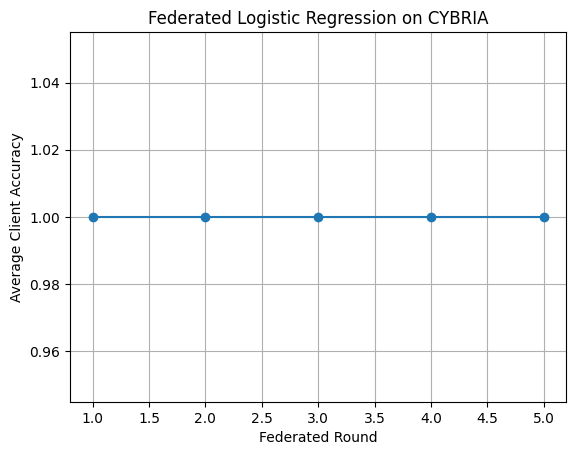

In [6]:
avg_acc_per_round = [sum(accs) / len(accs) for accs in server.round_accuracies]

plt.figure()
plt.plot(range(1, len(avg_acc_per_round) + 1), avg_acc_per_round, marker="o")
plt.xlabel("Federated Round")
plt.ylabel("Average Client Accuracy")
plt.title("Federated Logistic Regression on CYBRIA")
plt.grid(True)
plt.show()
